In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

# About.
This notebook is about Power Law Data. It explores the distribution of **finite sample** estimates for the mean and tail exponent.

### Permalink
[Click here](https://github.com/FergM/fattails/blob/main/notebooks/NB34%20-%20Tail%20Alpha%20Distribution.ipynb) for latest version of this notebook.

### Mean Estimation Methods
1. Naive Sample Mean
    * i.e. just calculate the sample mean. This can be very biased in the presence of skewness.
2. Plug-in Estimation
    * i.e. estimate the tail alpha first and use that to estimate the sample mean.

### Context
For background info see the Technical Incerto chapter called *Calibrating Under Paretianity*.

I use the Numpy package's Pareto Distribution:
* [Numpy Documentation](https://numpy.org/doc/stable/reference/random/generated/numpy.random.Generator.pareto.html#numpy.random.Generator.pareto)
* [Wikipedia](https://en.wikipedia.org/wiki/Pareto_distribution)
* Properties
    * pdf = alpha*x^(-alpha-1)
    * CDF = 1 - x^-alpha
    * Survival Function = x^-alpha
    * Mean = alpha/(alpha-1)

### Generate Samples

In [2]:
# Settings
alpha = 1.2  # The tail exponent

n = summand_count = 100  # The number of values in your sample average

sample_size = 100_000  # The number of monte carlos you want to run

In [3]:
# Random number generator
rng = np.random.default_rng()

In [4]:
# Samples
# ToDo: Explain the +1 term here...
samples = [rng.pareto(alpha, summand_count)+1 for idx in range(sample_size)]
samples[0][0:3]

array([7.71874151, 1.328448  , 1.46391072])

# Mean Estimates

In [5]:
# True Mean
true_mean = alpha/(alpha-1)
true_mean

6.000000000000001

In [6]:
# Sample Mean Values
sample_means = [sample.mean() for sample in samples]
sample_means[:3]

[3.060973357639481, 3.140643943814928, 2.9647158997498657]

In [7]:
# MLE Alpha Values
mle_alphas = [(summand_count-1)/(np.log(sample).sum()) for sample in samples]
mle_alphas[:3]

[1.2665939829546191, 1.24482971091516, 1.2875449608466047]

In [8]:
# MLE Mean Estimates
alpha_implied_mean = lambda alpha: (alpha/(alpha-1))
mle_means = [alpha_implied_mean(alpha) for alpha in mle_alphas]
mle_means[:3]

[4.751022393368213, 5.08447159563296, 4.477717004866816]

# Mean Distribution
Plot the distribution of sample mean estimates.

Put all the data in one table:

In [9]:
# Put data in a DataFrame
sample_means = pd.Series(sample_means)
mle_alphas = pd.Series(mle_alphas)
mle_means = pd.Series(mle_means)
df = pd.concat([mle_alphas, mle_means, sample_means], keys=['mle_alpha', 'mle_mean', 'sample_mean'], axis=1)
df.tail()

,mle_alpha,mle_mean,sample_mean
99995,1.056078,18.832402,4.203487
99996,1.160875,7.216024,3.934823
99997,0.996467,-282.009705,5.454379
99998,1.018729,54.392722,5.366482
99999,1.234867,5.257724,3.984053


Define the truncation conditions:

In [10]:
# Filter Conditions

# Only count alpha>1 cases for mle method
alpha_condition = df.mle_alpha > 1 # Truncate to remove alpha estimates less than one.

# Truncate the range before plotting for faster plots
mle_xlim_condition = df.mle_mean < 20  
sample_xlim_condition = df.sample_mean < 20  

Plot the distribution of mean estimates:

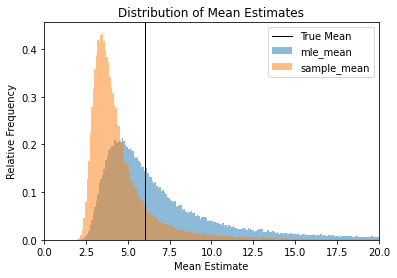

In [11]:
# Mean Estimation Method Comparison

# Mean extimated from MLE Alpha estimate
ax = df.mle_mean.loc[alpha_condition & mle_xlim_condition] \
       .plot(kind='hist', bins=200, xlim=[0, 20], alpha=0.5, \
             density=True, \
             title='Distribution of Mean Estimates');  # The alpha=0.5 parameter is just a matplotlib thing for plot shading

# Naive Sample Mean
df.sample_mean.loc[sample_xlim_condition] \
  .plot(kind='hist', bins=200, xlim=[0, 20], alpha=0.5, \
        density=True, \
        title='Distribution of Mean Estimates');

# True Mean
ax.axvline(true_mean, linewidth=1, color='k', label='True Mean');
plt.xlabel('Mean Estimate')
plt.ylabel('Relative Frequency')
plt.legend();

# Extra Stuff
Further exploration beyond what's in Incerto appendix C.

### Min Max Summary

In [12]:
# Without Truncation
df.agg(['min', 'max']).round(2)

,mle_alpha,mle_mean,sample_mean
min,0.81,-47325.17,1.9
max,1.98,197493.97,6265.9


In [13]:
# MLE Truncated
df.mle_mean.loc[alpha_condition & mle_xlim_condition] \
  .agg(['min', 'max']).round(2).to_frame()

,mle_mean
min,2.02
max,20.00


In [14]:
# Sample Mean Truncated
df.sample_mean.loc[sample_xlim_condition] \
  .agg(['min', 'max']).round(2).to_frame()

,sample_mean
min,1.9
max,20.0


### Alpha Distribution

Look at things in Alpha space:

In [15]:
# Convert sample means to implied alphas
mean_implied_alpha = lambda mean: (mean/(mean-1))

df['sample_mean_alpha'] = df.sample_mean.apply(mean_implied_alpha)

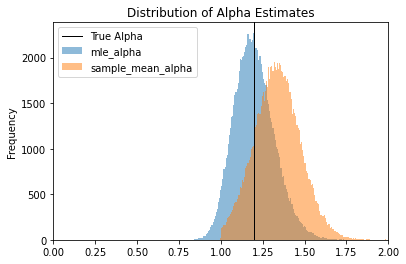

In [16]:
ax = df.filter(like='alpha') \
  .plot(kind='hist', bins=200, xlim=[0, 2], alpha=0.5, \
        title='Distribution of Alpha Estimates');

ax.axvline(alpha, linewidth=1, color='k', label='True Alpha' );
plt.legend();

### Alpha-Mean Relationship

In [18]:
# Define the Relationship
get_mean = lambda alpha: (alpha/(alpha-1))
get_alpha = lambda mean: (mean/(mean-1))

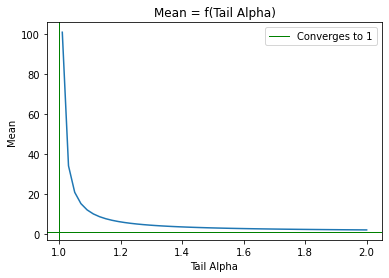

In [19]:
# Tail Alpha vs. Mean 

# Generate Points
alpha_range = np.linspace(1.01, 2)

# Plot
plt.plot(alpha_range, get_mean(alpha_range))

# Labels
plt.xlabel('Tail Alpha')
plt.ylabel('Mean')
plt.title('Mean = f(Tail Alpha)')

# Asymptote
plt.axhline(y=1, color='g', linewidth=1, label='Converges to 1')
plt.axvline(x=1, color='g', linewidth=1);

plt.legend()
plt.show()

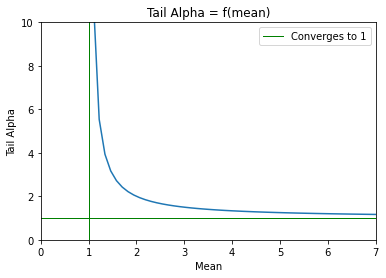

In [20]:
# Mean vs. Tail Alpha 

# Generate Points
mean_range = np.linspace(1.1, 7)

# Plot
plt.plot(mean_range, get_alpha(mean_range))

# Labels
plt.xlabel('Mean')
plt.ylabel('Tail Alpha')
plt.title('Tail Alpha = f(mean)')

# Range
plt.ylim([0,10])
plt.xlim([0, 7])

# Asymptote
plt.axhline(y=1, color='g', linewidth=1, label='Converges to 1')
plt.axvline(x=1, color='g', linewidth=1);

plt.legend()
plt.show()

### More Plots

In [ ]:
## Plot the Sample Mean Distribution on its own
#df.loc[sample_xlim_condition].sample_mean \
#  .plot(kind='hist', bins=200, xlim=[0, 20], \
#        title='Distribution of Sample Mean Estimates');

In [ ]:
## Plot the MLE Distribution on its own
#df.loc[alpha_condition & mle_mean_condition].mle_mean \
#  .plot(kind='hist', bins=200, xlim=[0, 20], \
#        title='Distribution of MLE Mean Estimates');